In [4]:
import numpy as np
%tensorflow_version 2.x
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

# TensorFlow has some popular datasets already included. 
# Check out https://www.tensorflow.org/api_docs/python/tf/keras/datasets.
# In this homework we will work with the popular MNIST dataset.
train_data = tfds.load(name='malaria', as_supervised=True)['train'];

BATCH=64
IMG_SIZE=150

### Load the dataset.

<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
27558
(103, 103, 3)
(106, 121, 3)
(139, 142, 3)
(130, 118, 3)
(121, 109, 3)


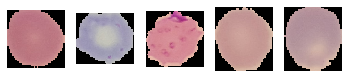

In [5]:
# Purely plotting
print(train_data)
print(len(train_data))

iterator=train_data.__iter__()
fig, ax = plt.subplots(1,5)
maxi=0
for i in range(5):

    # Readout an image and the corresponding label.
    img,lbl=iterator.get_next()
    print(img.shape)
    ax[i].imshow(img, interpolation='nearest')
    ax[i].axis("off")
  


### Build the TensorFlow dataset: Input pipeline

In [6]:
def transfi(tensor):
    result=tf.image.resize_with_pad(tensor,IMG_SIZE,IMG_SIZE)/256
    #normalizing, hope that these lines work (from my memory, couldn't test them on this laptop yet)
    maxi=tf.argmax(result)
    result/=maxi
    return result

# Convert input string into onehot tensor using above function
# Conver input label into onehot tensor using tf.one_hot
def transfi_data_input(input,label):
    return (transfi(input), tf.one_hot(label,depth=2))

# Function to process datasets
# Converts inputs and labels into onehot representations
# Converts inputs into batches of specified size
# Assumes inputs and targets are already zipped together (in tuple form)


def process_ds(ds, batch_size=64):  

    # Map all data points to their corresponding onehot representations
    dataset = ds.map(transfi_data_input)

    # Batch and shuffle
    dataset = dataset.batch(batch_size)
    dataset = dataset.shuffle(buffer_size=128)

    return dataset;

# Process loaded training dataset
train_dataset = process_ds(train_data)

# Process loaded test dataset
iterator=train_dataset.__iter__()
# Split into train and test
train_set=train_dataset.take(int(0.8*len(train_dataset)))
test_set=train_dataset.skip(int(0.8*len(train_dataset)))
"""
fig, ax = plt.subplots(1,5)
maxi=0
for i in range(5):

    # Readout an image and the corresponding label.
    img,lbl=iterator.get_next()
    print(img.shape,lbl)
    ax[i].imshow(img, interpolation='nearest')
    ax[i].axis("off")"""


(None, None, 3)
Tensor("truediv:0", shape=(100, 100, 3), dtype=float32)
431 344 87


'\nfig, ax = plt.subplots(1,5)\nmaxi=0\nfor i in range(5):\n\n    # Readout an image and the corresponding label.\n    img,lbl=iterator.get_next()\n    print(img.shape,lbl)\n    ax[i].imshow(img, interpolation=\'nearest\')\n    ax[i].axis("off")'

### Build the model.

In [10]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer

class Model(Model): 
    def __init__(self):
        super(Model, self).__init__()

        # Define the three layers.
        self.conv1=tf.keras.layers.Conv2D(filters=60,kernel_size=3,strides=(1,1),activation=tf.keras.activations.sigmoid,input_shape=(100,100,3))
        self.pool1=tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=None)
        self.conv2=tf.keras.layers.Conv2D(filters=60,kernel_size=3,strides=(1,1),activation=tf.keras.activations.sigmoid)
        self.pool2=tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=None)
        self.conv3=tf.keras.layers.Conv2D(filters=60,kernel_size=3,strides=(1,1),activation=tf.keras.activations.sigmoid)
        self.pool3=tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=None)
        self.hidden1 = tf.keras.layers.Dense(units=256, activation=tf.keras.activations.sigmoid)
        self.global1=tf.keras.layers.GlobalAveragePooling2D()
        self.hidden2 = tf.keras.layers.Dense(units=256, activation=tf.keras.activations.sigmoid)
        self.output1 = tf.keras.layers.Dense(units=2, activation=tf.keras.activations.softmax)
    def call(self, inputs):      
        # Define the forward step.
        return self.output1(self.hidden2(self.global1(self.hidden1((self.pool3(self.conv3(self.pool2(self.conv2(self.conv2(self.conv1(inputs)))))))))))

### Train the model.

In [8]:
#taken from the courseware-notebook

def train_step(model, input, target, loss_function, optimizer):

    with tf.GradientTape() as tape:
        prediction = model(input)
        loss = loss_function(target, prediction)
        gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss 

def test(model, test_data, loss_function):
    test_accuracy_aggregator = []
    test_loss_aggregator = []

    for (input, target) in test_data:
        prediction = model(input)
        sample_test_loss = loss_function(target, prediction)
        sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
        sample_test_accuracy = np.mean(sample_test_accuracy)
        test_loss_aggregator.append(sample_test_loss.numpy())
        test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

    test_loss = np.mean(test_loss_aggregator)
    test_accuracy = np.mean(test_accuracy_aggregator)

    return test_loss, test_accuracy
  



In [11]:
#taken from the courseware-notebook, the running average was removed

tf.keras.backend.clear_session()

### Hyperparameters
num_epochs = 20
learning_rate = 0.0001

# Initialize the model.
model = Model()
# Initialize the loss: categorical cross entropy.
cross_entropy_loss = tf.keras.losses.BinaryCrossentropy()
# Initialize the optimizer: Adam with default parameters. 
optimizer = tf.keras.optimizers.SGD(learning_rate)

# Initialize lists for later visualization.
train_losses = []

test_losses = []
test_accuracies = []

# We train for num_epochs epochs.
for epoch in range(num_epochs):
    print('Epoch: __ ' + str(epoch))

    train_set = train_set.shuffle(buffer_size=64)
    test_set = test_set.shuffle(buffer_size=64)

    #training (and checking in with training)
    train_loss=0
    for (inputs,target) in train_set:
        train_loss += train_step(model, inputs, target, cross_entropy_loss, optimizer)
        print("h")
    train_losses.append(train_loss/len(train_set))

    #testing
    test_loss, test_accuracy = test(model, test_set, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)



Streaming output truncated to the last 5000 lines.
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
Epoch: __ 6
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h

### Visualize the training progress.

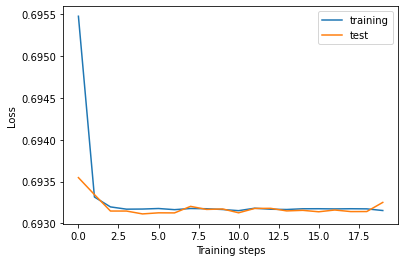

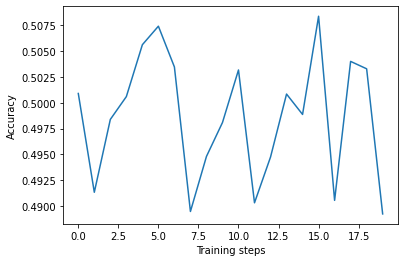

In [12]:
#taken from the courseware notebook

# Visualize accuracy and loss for training and test data. 
# One plot training and test loss.
# One plot training and test accuracy.
plt.figure()
x = list(range(num_epochs));
line1, = plt.plot(x, train_losses, label='training')
line2, = plt.plot(x, test_losses, label='test')
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure()
line1, = plt.plot(test_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Accuracy")
plt.show()
